# Physics Informed Neural Networks (PINNs) for 1D Heat Equation

## 1. Introduction
In this workbook, we would be training a physics informed neural network model for 1D Heat equation.

$$\frac{\partial u}{\partial t} - \nu \frac{\partial^2 u}{\partial x^2} = 0$$

Physics informed neural networks is made of a dense neural network that takes in the $(x,t)$ points in the domain and learns the physics from it using PDEs such as the one just above. 

The architecture of the network looks something like this:

![](https://www.researchgate.net/profile/Zhen-Li-105/publication/335990167/figure/fig1/AS:806502679982080@1569296631121/Schematic-of-a-physics-informed-neural-network-PINN-where-the-loss-function-of-PINN.ppm)

We will begin the workbook with few imports and creating some helper functions

## 2. Imports and helper functions

In [3]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import time 
import matplotlib.pyplot as plt
t0 = time.time()

def plot(geom_time,data,name):
    plt.figure()
    plt.scatter(geom_time[:,0], geom_time[:,1],s = 20, c=np.reshape(data, (len(data),)), cmap='jet')
    plt.colorbar()
    plt.xlabel('x domain')
    plt.ylabel('time domain')
    plt.title(name)
    plt.show()
    
# define the PDE for 1D Heat equations
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

    return (
        dy_t
        - dy_xx*0.3)
    

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

## 2. initialization
Initialize the geometry, time domain and the Dirichlet BC and IC

In [4]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func,
    num_test=1000,
)

/miniconda/lib/python3.7/site-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+4002=4002. 
  total_n_samples))
/miniconda/lib/python3.7/site-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2002=2002. 
  total_n_samples))
/miniconda/lib/python3.7/site-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  total_n_samples))


Initialize the network and compile the model

In [5]:
layer_size = [2] + [32] * 3 + [1]

activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.054870 s



/miniconda/lib/python3.7/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/miniconda/lib/python3.7/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.426884 s



## 3. Training


In [6]:
t1 = time.time()

losshistory, train_state = model.train(epochs=10000)

t2 = time.time()
print("training time:",(t2-t1))

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [6.29e-02, 2.66e-01, 2.52e-01]    [5.97e-02, 2.66e-01, 2.52e-01]    [1.11e+00]    
1000      [1.53e-03, 1.78e-03, 6.78e-04]    [1.19e-03, 1.78e-03, 6.78e-04]    [2.88e-01]    
2000      [8.38e-04, 4.54e-04, 2.02e-04]    [7.09e-04, 4.54e-04, 2.02e-04]    [2.82e-01]    
3000      [3.76e-04, 1.01e-04, 7.60e-05]    [3.90e-04, 1.01e-04, 7.60e-05]    [2.81e-01]    
4000      [1.84e-04, 5.35e-05, 4.70e-05]    [2.00e-04, 5.35e-05, 4.70e-05]    [2.81e-01]    
5000      [1.01e-04, 2.34e-05, 2.43e-05]    [1.22e-04, 2.34e-05, 2.43e-05]    [2.81e-01]    
6000      [7.84e-05, 3.08e-05, 4.57e-05]    [8.66e-05, 3.08e-05, 4.57e-05]    [2.81e-01]    
7000      [5.54e-05, 8.78e-06, 1.05e-05]    [6.50e-05, 8.78e-06, 1.05e-05]    [2.81e-01]    
8000      [9.01e-05, 5.69e-05, 4.63e-05]    [7.56e-05, 5.69e-05, 4.63e-05]    [2.83e-01]    
9000      [4.22e-05, 4.46

## 4. Post-training Visualization

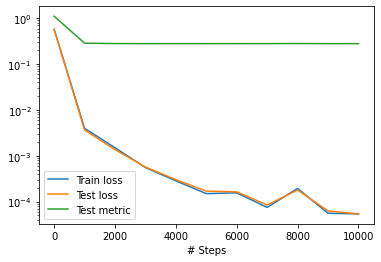

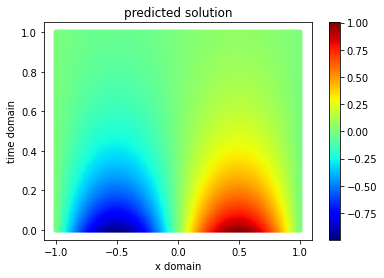

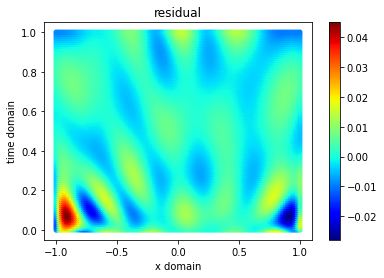

total time
330.84191632270813


In [7]:
dde.postprocessing.plot_loss_history(losshistory)
plt.show()


x_data = np.linspace(-1,1,num = 100)
t_data = np.linspace(0,1,num = 100)
test_x , test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain,operator=pde)



plot(test_domain,predicted_solution,"predicted solution")


plot(test_domain,residual,"residual")


print("total time")
print(t2-t0)